# Modelling Wti Price

In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv("data/datewise_news_with_price.csv")

In [3]:
def prev(colm,day):
    l=[]
    for _ in range(int(day)):
        l.extend([np.NaN])
    l.extend(list(colm[:-day]))
    return l

In [4]:
def new_col(datafrm,the_col,upto_previous):
    '''
    datafrm: The dataframe
    the_col: The column which should have previous values
    upto_previous: Upto how many days we should take the previous prices
    '''
    for i in range(upto_previous):
        col_name=the_col.name+str(-i-1)
#         print(len(prev(the_col,i)))
        datafrm[col_name]=prev(the_col,i+1)
    return datafrm

In [5]:
data1 = new_col(data,data.Wti_Close,10).dropna(axis=0)

In [6]:
data1 = data1.reset_index().drop(columns = 'index')

In [7]:
data2 = data1.drop(columns = ['text','sentiment','Brent_Close','Brent_Volume'])

In [8]:
data2

,date,neutral_score,positive_score,negative_score,Wti_Close,Wti_Volume,Wti_Close-1,Wti_Close-2,Wti_Close-3,Wti_Close-4,Wti_Close-5,Wti_Close-6,Wti_Close-7,Wti_Close-8,Wti_Close-9,Wti_Close-10
0,2010-10-27,5.004848,-3.480374,-5.875779,82.18,296748.0,81.94,82.55,81.69,80.56,81.77,79.49,81.25,82.69,83.01,81.67
1,2010-10-28,7.814564,-5.796148,-5.507691,81.43,313874.0,82.18,81.94,82.55,81.69,80.56,81.77,79.49,81.25,82.69,83.01
2,2010-11-01,1.544746,0.810681,-6.695308,83.90,281834.0,81.43,82.18,81.94,82.55,81.69,80.56,81.77,79.49,81.25,82.69
3,2010-11-02,3.366786,-0.777025,-6.400273,84.69,393735.0,83.90,81.43,82.18,81.94,82.55,81.69,80.56,81.77,79.49,81.25
4,2010-11-03,5.098197,-3.602260,-4.911095,86.49,317997.0,84.69,83.90,81.43,82.18,81.94,82.55,81.69,80.56,81.77,79.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2434,2022-01-31,4.107919,-1.145803,-5.348387,88.15,436172.0,86.82,86.61,87.35,85.60,83.31,85.14,86.90,86.96,85.43,83.82
2435,2022-02-01,3.324828,-1.544067,-5.665248,88.20,376841.0,88.15,86.82,86.61,87.35,85.60,83.31,85.14,86.90,86.96,85.43
2436,2022-02-02,-6.357212,12.092671,-7.984995,88.26,456863.0,88.20,88.15,86.82,86.61,87.35,85.60,83.31,85.14,86.90,86.96
2437,2022-02-03,5.883592,-4.641930,-3.044854,90.27,465771.0,88.26,88.20,88.15,86.82,86.61,87.35,85.60,83.31,85.14,86.90


In [9]:
y = data2['Wti_Close'] #next_close
cols = ['Wti_Volume', 'Wti_Close-1','Wti_Close-2','Wti_Close-3',
       'Wti_Close-4','Wti_Close-4','Wti_Close-5','Wti_Close-6','Wti_Close-7','Wti_Close-8','Wti_Close-9','Wti_Close-10']
x = data2[cols]

In [10]:
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
from keras.models import model_from_json
from keras.models import load_model
from keras import regularizers

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
fmt = '$%.0f'
tick = mtick.FormatStrFormatter(fmt)

%matplotlib inline

In [11]:
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(data)-1))

# 80% of data will be of training
train_end = int(data_to_use*0.8)

total_data = len(data)
print("total_data:", total_data)

total_data: 2449


In [12]:
y1=y

In [13]:
scaler_x = preprocessing.MinMaxScaler(feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

scaler_y = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

In [14]:
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  
y1_test = y1[train_end+1 : len(y)]  

X_train = X_train.reshape (X_train. shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

In [15]:
X_train.shape

(1958, 12, 1)

In [16]:
model = Sequential()
model.add(LSTM(32, input_shape = (len(cols), 1), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
batch_size = 32
nb_epoch = 1000
neurons = 25
dropout = 0.1

model.compile(loss='mean_squared_error' , optimizer='Adam')
model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_split=0.2)

Epoch 1/1000
49/49 [==============================] - 3s 20ms/step - loss: 0.1017 - val_loss: 0.0053
Epoch 2/1000
49/49 [==============================] - 1s 15ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 3/1000
49/49 [==============================] - 1s 14ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 4/1000
49/49 [==============================] - 1s 14ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 5/1000
49/49 [==============================] - 1s 13ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 6/1000
49/49 [==============================] - 1s 12ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 7/1000
49/49 [==============================] - 1s 16ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 8/1000
49/49 [==============================] - 1s 13ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 9/1000
49/49 [==============================] - 1s 13ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 10/1000
49/49 [==============================] - 1s 13ms/step - loss: 0.0029 - val_lo

In [18]:
score_train = model.evaluate(X_train, y_train, batch_size =1)
score_test = model.evaluate(X_test, y_test, batch_size =1)
print("in train MSE = ", round( score_train ,4)) 
print("in test MSE = ", score_test )

480/480 [==============================] - 1s 2ms/step - loss: 0.0050
in train MSE =  0.001
in test MSE =  0.004975808318704367


In [19]:
model_json = model.to_json()
with open("model/model_adam.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model/model_adam.h5")
print("Saved model to disk")

Saved model to disk


In [20]:
pred = model.predict(X_test) 
pred = scaler_y.inverse_transform(np.array(pred).reshape((len(pred), 1)))

prediction_data = pred[-1]     

print ("Inputs: {}".format(model.input_shape))
print ("Outputs: {}".format(model.output_shape))
print ("Actual input: {}".format(X_test.shape))
print ("Actual output: {}".format(y_test.shape))

print ("prediction data:")
print (prediction_data)

print ("actual data")
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))
print (X_test)

Inputs: (None, 12, 1)
Outputs: (None, 1)
Actual input: (480, 12, 1)
Actual output: (480, 1)
prediction data:
[89.26925]
actual data
[[7.18724e+05 5.81100e+01 5.84100e+01 ... 5.70500e+01 5.77200e+01
  5.67700e+01]
 [6.16423e+05 5.51700e+01 5.81100e+01 ... 5.52100e+01 5.70500e+01
  5.77200e+01]
 [5.60554e+05 5.59600e+01 5.51700e+01 ... 5.71100e+01 5.52100e+01
  5.70500e+01]
 ...
 [4.56863e+05 8.82000e+01 8.81500e+01 ... 8.51400e+01 8.69000e+01
  8.69600e+01]
 [4.65771e+05 8.82600e+01 8.82000e+01 ... 8.33100e+01 8.51400e+01
  8.69000e+01]
 [4.65771e+05 9.02700e+01 8.82600e+01 ... 8.56000e+01 8.33100e+01
  8.51400e+01]]


In [21]:
y1_test

1959    55.17
1960    55.96
1961    56.10
1962    58.43
1963    58.43
        ...  
2434    88.15
2435    88.20
2436    88.26
2437    90.27
2438    92.31
Name: Wti_Close, Length: 480, dtype: float64

In [23]:
l = []
for i in y1_test:
    l.append(i)

In [24]:
l_pred=[i[0] for i in pred]

In [25]:
df= pd.DataFrame({"Original":l,"Predicted":l_pred})

In [26]:
df

,Original,Predicted
0,55.17,57.923290
1,55.96,55.772812
2,56.10,55.209595
3,58.43,55.251007
4,58.43,57.407738
...,...,...
475,88.15,85.355980
476,88.20,86.927948
477,88.26,87.029922
478,90.27,87.066605


<AxesSubplot:>

<Figure size 1224x504 with 0 Axes>

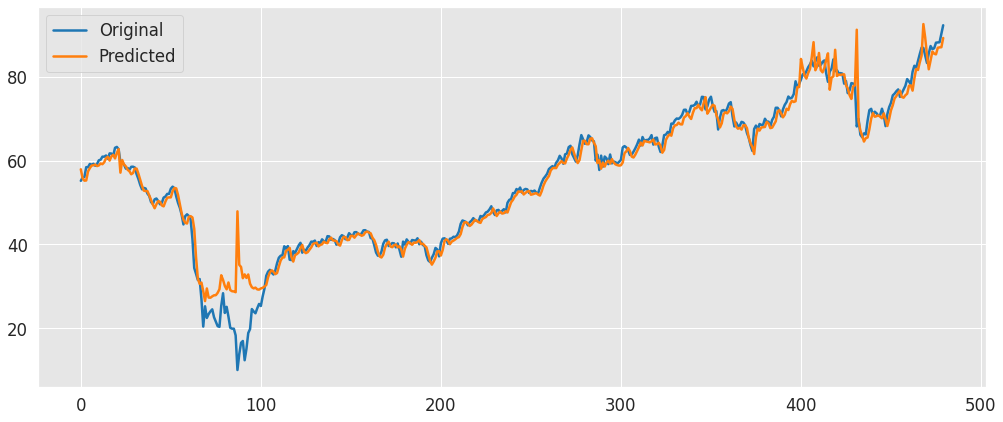

In [27]:
import seaborn as sns
plt.figure(figsize=(17,7))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
df.plot(figsize=(17,7))